### Домашнее задание к уроку 6

__1.__ Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [70]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [53]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [80]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
#  закомментировано (смотрела разбор ДЗ)   
#     predictions = np.array(
#         [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
#     )

# стало
       
    predictions = np.array(
        sum([eta * alg.predict(X) for alg in trees_list]) 
    )

    return predictions

In [81]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [56]:
def residual(y, z):
    return - (z - y)

In [57]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
#           Закомментировано Лазарева (            
#             train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
#             test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
#           Закомментировано Лазарева )        
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
#             Закомментировано Лазарева (
#             train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
#             test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
#             Закомментировано Лазарева )

        trees.append(tree)
        train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
    return trees, train_errors, test_errors

In [58]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [59]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [82]:
max_depth = 3
errors_train = []
errors_test = []

for i in tqdm(range(1,51)):
    n_trees = i
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.74it/s]


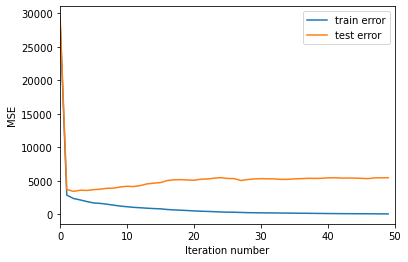

In [83]:
get_error_plot(50, train_errors, test_errors)

In [104]:
n_trees = 3
errors_train = []
errors_test = []

for i in tqdm(range(1,16)):
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
    trees, train_errors, test_errors = gb_fit(n_trees, i, X_train, X_test, y_train, y_test, eta)  
    
    errors_train.append(train_errors[2])
    errors_test.append(test_errors[2])

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 204.05it/s]


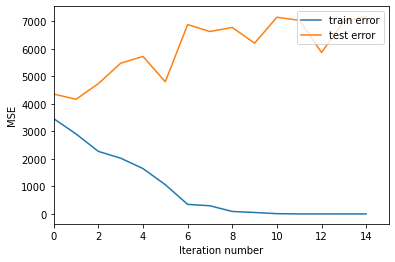

In [105]:
get_error_plot(15, errors_train, errors_test)

__Вывод__ При увеличении количества деревьев ошибка на тренировочной выборке уменьшается, а на тестовой выборке растет.
С увеличением глубины деревьев растет переобучение. Оптимальная глубина для данной выборки - 3

2. *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

3. *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.